## Churn Prediction for Tours and Travels industry using Lazy Predict Library

Customer churn, also known as customer attrition, refers to the phenomenon where customers cease their relationship with a business or discontinue using its products or services. It is a critical concern for businesses across industries, as the loss of customers can have a substantial impact on revenue and long-term sustainability. y analyzing patterns and identifying early warning signs, businesses can proactively implement retention strategies, reduce churn rates, and ultimately improve customer satisfaction and loyalty.

### Importing libraries

In [1]:
pip install lazypredict

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer


In [4]:
data = pd.read_csv("/content/Customertravel.csv")
data.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0
3,30,No,Middle Income,2,No,No,0
4,30,No,Low Income,1,No,No,0


In [5]:
data.columns    #display the columns present in the dataset/dataframe

Index(['Age', 'FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted',
       'AccountSyncedToSocialMedia', 'BookedHotelOrNot', 'Target'],
      dtype='object')

In [6]:
data.info()     #display information relevant to our dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         954 non-null    int64 
 1   FrequentFlyer               954 non-null    object
 2   AnnualIncomeClass           954 non-null    object
 3   ServicesOpted               954 non-null    int64 
 4   AccountSyncedToSocialMedia  954 non-null    object
 5   BookedHotelOrNot            954 non-null    object
 6   Target                      954 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 52.3+ KB


In [7]:
data.isnull().sum()       #checking the presence of any null values

Age                           0
FrequentFlyer                 0
AnnualIncomeClass             0
ServicesOpted                 0
AccountSyncedToSocialMedia    0
BookedHotelOrNot              0
Target                        0
dtype: int64

In [8]:
data.shape

(954, 7)

In [9]:
#renaming the column 'Target' to 'Status' just for the ease of interpretation
data.rename(columns={'Target': 'Status'}, inplace=True)


In [10]:
#in the given dataset 0 represents that the customer hasn't churned i.e., the customer has retained. We are hence renaming it as such for better readability
data['Status'] = data['Status'].map({0: 'retained', 1 : 'dropped'})


In [11]:
print(data['Status'].value_counts())   #counting the number of customers reatined and dropped

retained    730
dropped     224
Name: Status, dtype: int64


In [12]:
data.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Status
0,34,No,Middle Income,6,No,Yes,retained
1,34,Yes,Low Income,5,Yes,No,dropped
2,37,No,Middle Income,3,Yes,No,retained
3,30,No,Middle Income,2,No,No,retained
4,30,No,Low Income,1,No,No,retained


### Data Visualization

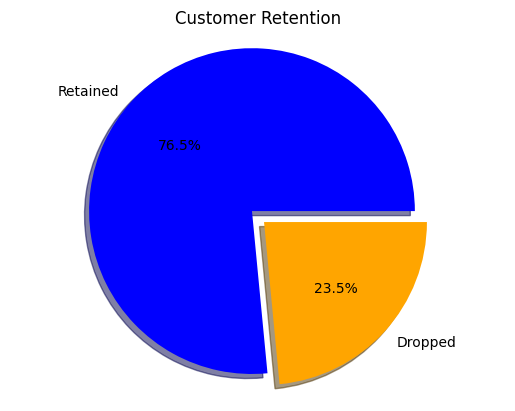

In [13]:
retained_count = data[data['Status'] == 'retained'].shape[0]
dropped_count = data[data['Status'] == 'dropped'].shape[0]
labels = ['Retained', 'Dropped']
explode = (0,0.1)
sizes = [retained_count, dropped_count]
plt.pie(sizes, labels=labels, colors=['blue','orange'], autopct='%1.1f%%', shadow = True, explode = explode)

plt.axis('equal')
plt.title('Customer Retention')

# Displaying the chart
plt.show()

<Axes: xlabel='ServicesOpted', ylabel='count'>

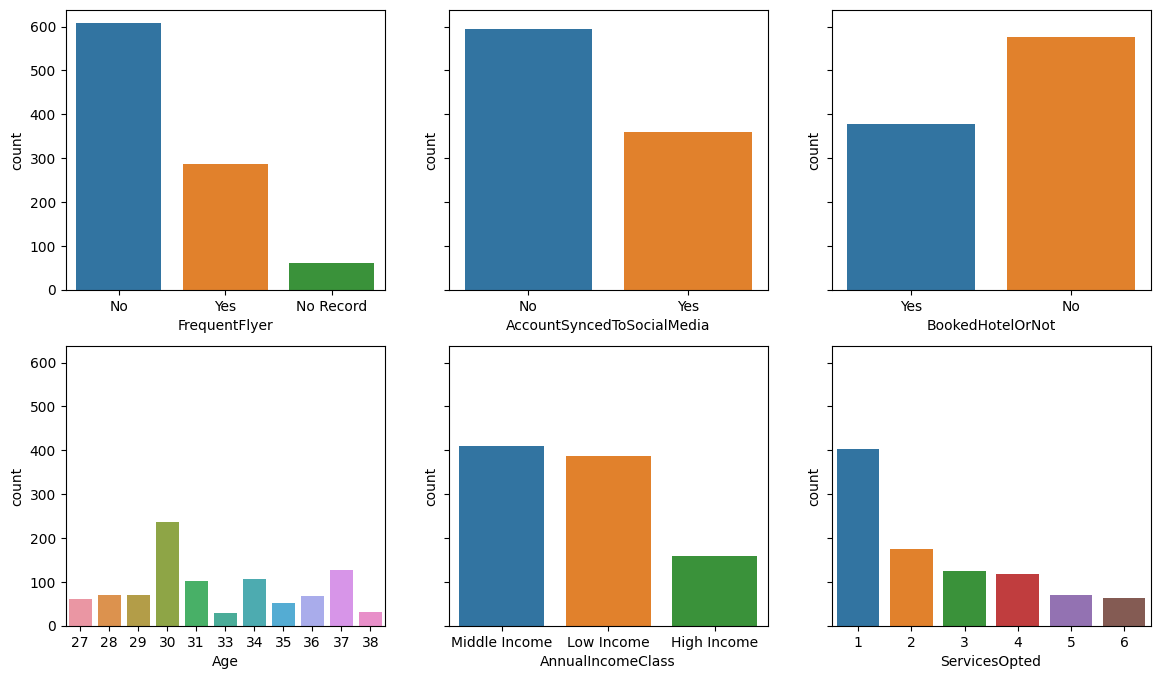

In [14]:
fig, axes = plt.subplots(2,3, figsize=(14,8), sharey=True)
sns.countplot(x='FrequentFlyer', data=data, ax=axes[0,0])
sns.countplot(x='AccountSyncedToSocialMedia', data=data, ax=axes[0,1])
sns.countplot(x='BookedHotelOrNot',data=data, ax=axes[0,2])
sns.countplot(x='Age',data=data, ax=axes[1,0])
sns.countplot(x='AnnualIncomeClass',data=data, ax=axes[1,1])
sns.countplot(x='ServicesOpted',data=data, ax=axes[1,2])

In [15]:
data.dtypes

Age                            int64
FrequentFlyer                 object
AnnualIncomeClass             object
ServicesOpted                  int64
AccountSyncedToSocialMedia    object
BookedHotelOrNot              object
Status                        object
dtype: object

### Data Preprocessing

In [16]:
encoded_data = data.copy()

In [17]:
#converting to categorical variables
encoded_data['FrequentFlyer'] = encoded_data['FrequentFlyer'].astype('category')
encoded_data['AnnualIncomeClass'] = encoded_data['AnnualIncomeClass'].astype('category')
encoded_data['AccountSyncedToSocialMedia'] = encoded_data['AccountSyncedToSocialMedia'].astype('category')
encoded_data['BookedHotelOrNot'] = encoded_data['BookedHotelOrNot'].astype('category')


In [18]:
encoded_data.dtypes

Age                              int64
FrequentFlyer                 category
AnnualIncomeClass             category
ServicesOpted                    int64
AccountSyncedToSocialMedia    category
BookedHotelOrNot              category
Status                          object
dtype: object

In [19]:
encoded_data.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Status
0,34,No,Middle Income,6,No,Yes,retained
1,34,Yes,Low Income,5,Yes,No,dropped
2,37,No,Middle Income,3,Yes,No,retained
3,30,No,Middle Income,2,No,No,retained
4,30,No,Low Income,1,No,No,retained


In [20]:
#encoding the categorical variables
encoded_data['FrequentFlyer'] = encoded_data['FrequentFlyer'].cat.codes
encoded_data['AnnualIncomeClass'] = encoded_data['AnnualIncomeClass'].cat.codes
encoded_data['AccountSyncedToSocialMedia'] = encoded_data['AccountSyncedToSocialMedia'].cat.codes
encoded_data['BookedHotelOrNot'] = encoded_data['BookedHotelOrNot'].cat.codes

In [21]:
encoded_data.dtypes

Age                            int64
FrequentFlyer                   int8
AnnualIncomeClass               int8
ServicesOpted                  int64
AccountSyncedToSocialMedia      int8
BookedHotelOrNot                int8
Status                        object
dtype: object

In [22]:
encoded_data['Status'] = encoded_data['Status'].map({'retained': 0, 'dropped' : 1})


In [23]:
encoded_data.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Status
0,34,0,2,6,0,1,0
1,34,2,1,5,1,0,1
2,37,0,2,3,1,0,0
3,30,0,2,2,0,0,0
4,30,0,1,1,0,0,0


In [24]:
encoded_data.to_csv('encoded_data.csv', index=False)
files.download('encoded_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
x = encoded_data.drop('Status',axis=1)
y = encoded_data['Status']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2,random_state=40)

### Model/Algorithm Application

There are a lot of alogorithms that can be applied for churn prediction namely XGBoost, Logistic Regression, DecisionTree, SVMs and other neural networks. It is for us to decide after looking and working with the data, which one to use.

Here we will be using multiple algorithms/models and compare the same using their accuracy to judge what fits the best for our chosen dataset.

#### XGBoost

In [27]:
model1 = XGBClassifier()

In [28]:
model1.fit(x_train,y_train)
y_pred1 = model1.predict(x_test)

In [29]:
print("Accuracy Score :", accuracy_score(y_test, y_pred1)*100, "%")


Accuracy Score : 92.14659685863874 %


#### Linear Support Vector Classifier

In [30]:
model2 = LinearSVC()

In [31]:
model2.fit(x_train,y_train)
y_pred2 = model2.predict(x_test)
print("Accuracy Score :", accuracy_score(y_test, y_pred2)*100, "%")


Accuracy Score : 79.05759162303664 %


#### Random Forest

In [32]:
model3 = RandomForestClassifier()

In [33]:
model3.fit(x_train,y_train)
y_pred3 = model3.predict(x_test)
print("Accuracy Score :", accuracy_score(y_test, y_pred3)*100, "%")


Accuracy Score : 91.62303664921467 %


#### Artificial Neural Network

In [34]:
model_4 = Sequential([Dense(64, activation='relu', input_shape=(6,)),
                      BatchNormalization(),
                      Dense(32, activation='relu'),
                      BatchNormalization(),
                      Dense(16, activation='relu'),
                      BatchNormalization(),
                      Dense(8, activation='relu'),
                      BatchNormalization(),
                      Dense(1, activation='sigmoid')
                      ])


In [35]:
model_4.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [36]:
model_4.fit(x_train, y_train, epochs=25)

Epoch 1/25
24/24 [==============================] - 7s 8ms/step - loss: 0.0000e+00 - accuracy: 0.6697
Epoch 2/25
24/24 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.7287
Epoch 3/25
24/24 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.7497
Epoch 4/25
24/24 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.7602
Epoch 5/25
24/24 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.7654
Epoch 6/25
24/24 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.7706
Epoch 7/25
24/24 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.7969
Epoch 8/25
24/24 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.7942
Epoch 9/25
24/24 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 0.7877
Epoch 10/25
24/24 [==============================] - 0s 7ms/step - loss: 0.000

In [37]:
loss, accuracy = model_4.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

6/6 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8429
Test Loss: 0.0
Test Accuracy: 0.8429319262504578


Upon comparing we notice that for our data, XGBoost yields the highest accuracy of ~92%

In [39]:
classifier = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = classifier.fit(x_train, x_test, y_train, y_test)


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


In [40]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BaggingClassifier                  0.93               0.92     0.92      0.93   
DecisionTreeClassifier             0.94               0.90     0.90      0.94   
LGBMClassifier                     0.93               0.90     0.90      0.93   
XGBClassifier                      0.92               0.89     0.89      0.92   
RandomForestClassifier             0.92               0.88     0.88      0.92   
ExtraTreesClassifier               0.92               0.87     0.87      0.92   
LabelPropagation                   0.91               0.87     0.87      0.91   
LabelSpreading                     0.91               0.87     0.87      0.91   
ExtraTreeClassifier                0.89               0.85     0.85      0.89   
KNeighborsClassifier               0.88               0.78     0.78      0.88   
SGDClassifier               

In [41]:
models.sort_values('Balanced Accuracy', ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BaggingClassifier,0.93,0.92,0.92,0.93,0.15
DecisionTreeClassifier,0.94,0.90,0.90,0.94,0.08
LGBMClassifier,0.93,0.90,0.90,0.93,0.19
XGBClassifier,0.92,0.89,0.89,0.92,0.18
RandomForestClassifier,0.92,0.88,0.88,0.92,0.37
ExtraTreesClassifier,0.92,0.87,0.87,0.92,0.23
LabelPropagation,0.91,0.87,0.87,0.91,0.06
LabelSpreading,0.91,0.87,0.87,0.91,0.13
ExtraTreeClassifier,0.89,0.85,0.85,0.89,0.03


The above AutoML tool displays that Bagging Classifer will bes best suited for our data and will result in the best accuracy

The BaggingClassifier is an ensemble learning method in machine learning. It is a meta-estimator that combines multiple individual classifiers, referred to as base estimators or base classifiers, to form a more robust and accurate model.It works by creating multiple subsets of the original dataset through random sampling with replacement. Each subset is used to train a separate base classifier. The predictions from all base classifiers are then combined using voting (for classification) or averaging (for regression) to make the final prediction.

In [43]:
bagging = BaggingClassifier()

In [46]:
param_grid = {
    'n_estimators': [50],  # Number of base estimators
    'max_samples': [0.5, 0.7, 1.0],  # Proportion of samples to draw from the training set
    'max_features': [0.5, 0.7, 1.0],  # Proportion of features to draw from the training set
    'bootstrap': [True, False]  # Whether samples are drawn with replacement
}

In [50]:
scorer = make_scorer(balanced_accuracy_score)


In [51]:
grid_search = GridSearchCV(bagging, param_grid, cv=5, scoring = scorer)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=BaggingClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [0.5, 0.7, 1.0],
                         'max_samples': [0.5, 0.7, 1.0], 'n_estimators': [50]},
             scoring=make_scorer(balanced_accuracy_score))

In [53]:
y_pred = grid_search.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9214659685863874


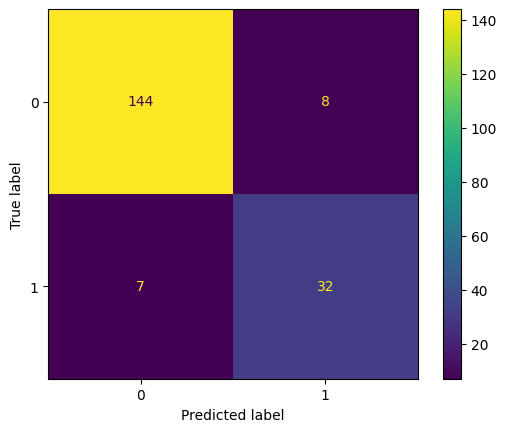

In [61]:
cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot()


To know more about Customer Churn Prediction and its practical applications in businesses, refer this: https://medium.com/@12gunika/unlocking-customer-loyalty-the-power-of-data-science-in-churn-prediction-26b529b8fcf0

Find more info about Lazy Predict library here: https://www.analyticsvidhya.com/blog/2021/05/lazy-predict-best-suitable-model-for-you/